In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# loading the data
data = pd.read_csv('house-prices.csv')
print('Dataset has {} entries and {} features.'.format(data.shape[0], data.shape[1]))

Dataset has 2430 entries and 82 features.


In [3]:
# classify variables

# this will be helpful when encoding by variable types

# 1 - Numeric variables
numeric = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
          '1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Garage Area','Wood Deck SF','Open Porch SF',
           'Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val',
          ]
# 2 - Categorical variables
# 2.1 - Categorical variables, ordinal (possibility of ordering)
categorical_ordinal = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual',
                      'Exter Cond','Bsmt Qual', 'Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                      'Heating QC','Electrical','Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual',
                       'Garage Cond','Paved Drive','Pool QC','Fence'
                      ]
# 2.2 - Categorical variables, nominal (no possibility to order) 
categorical_nominal = ['MS SubClass','MS Zoning','Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood',
                      'Condition 1', 'Condition 2', 'Bldg Type','House Style','Roof Style', 'Roof Matl','Exterior 1st',
                      'Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Misc Feature',
                       'Sale Type','Sale Condition'
                      ]
# 2.3 - Categorical variables, discrete
categorical_discrete = ['Year Built', 'Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath',
                       'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt','Garage Cars','Mo Sold',
                        'Yr Sold'
                       ]
categorical = categorical_ordinal + categorical_nominal + categorical_discrete

In [4]:
# Function for preprocessing the data
def preprocess_df(df):
    
    #handling the missing values
    columns_to_drop = ['PID', 'Order']
    columns_to_zero = ['Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Bsmt Half Bath', 'Bsmt Full Bath', 
                      'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF']
    columns_to_NA = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Garage Type','Garage Yr Blt',
                 'Garage Finish','Garage Qual','Garage Cond', 'Bsmt Qual' , 'Bsmt Cond' , 'Bsmt Exposure' ,
                 'BsmtFin Type 1' , 'BsmtFin Type 2']
    columns_to_none = ['Mas Vnr Type']
    columns_to_mean = ['Mas Vnr Area', 'Lot Frontage']
    columns_to_mode = ['Electrical']
    df_clean = df.copy()
    df_clean = df_clean.drop(columns_to_drop, axis=1)
    df_clean[columns_to_zero] = df[columns_to_zero].fillna(0)
    df_clean[columns_to_NA] = df[columns_to_NA].fillna('NA')
    df_clean[columns_to_none] = df[columns_to_none].fillna('None')
    df_clean[columns_to_mean] = df[columns_to_mean].fillna(df[columns_to_mean].mean())
    df_clean[columns_to_mode] = df[columns_to_mode].fillna(df[columns_to_mode].mode().iloc[0,0]) 
    
    #Remove outliers : very large houses (more than 4000 square feet)
    df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]
    
    # Feature engineering:
    #Add a LogSalePrice variable to the DataFrame:
    df_clean['LogSalePrice'] = np.log10(df_clean['SalePrice'])
    # Total surface count
    df_clean['Total_SF'] = df_clean['Total Bsmt SF'] + df_clean['Gr Liv Area']
    # Total room count
    df_clean['Total_rooms'] = (df_clean['TotRms AbvGrd'] + df_clean['Bsmt Full Bath'] +
                               df_clean['Bsmt Half Bath'] + df_clean['Full Bath'] + df_clean['Half Bath']) 
    # Built before 1980 & no remodeling
    df_clean['Built/Re bef 80'] = (df_clean['Year Remod/Add'] >1980)*1
    return df_clean

In [5]:
df_clean = preprocess_df(data)

In [6]:
# Final check for missing values
df_clean.isnull().sum().sum()

0

### 1.3 Outliers

### TO DO : 
1. define a function to exclude outliers on the validation set

In [ ]:
# Find outliers:
# plot of SALE PRICE versus GR LIV AREA 
plt.Figure(figsize=(8,8))
plt.scatter(data['SalePrice'], data['Gr Liv Area'] );

In [ ]:
#Remove very large houses (more than 4000 square feet) (this is included in the preprocessing function)
#df_clean = df_clean[df_clean['Gr Liv Area'] < 4000]

In [ ]:
#impact of removing theses 4 outliers
a = df_clean['Gr Liv Area'].describe() - data['Gr Liv Area'].describe()
print(a)
plt.Figure(figsize=(8,8))
plt.scatter(df_clean['SalePrice'], df_clean['Gr Liv Area']  );
plt.show()

## 2. Encoding

#### I defined 2 ways to encode the data frame:####
0. First, encoding the ordinal variables by assigning a value from 0 (none) / 1 (poor) to 5 or 6 (excellent) to these variables with the .replace method, then either:
    1. One-hot encoding nominal variables with pandas.get_dummies() (df_ohe)
    2. Label Encoding categorical nominal variables with sklearn LabelEncoder (df_le)
1. *what to do with discrete variables. ?*

In [7]:
## FUNCTION TO FINISH ##
# return 2 df, one with ohe, the other with labeling 
def encode(df):
    # Encoding Ordinal variables:
    # assigning a value from 0 (none) / 1 (poor) to 5 or 6 (excellent) to these variables
    quality_features = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual',
                    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Pool QC']
    df[quality_features] = df[quality_features].replace({
        'Ex' : 5, 'Gd' : 4,'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0
    })
    
    # Encoding other ordinal variables, with specific 'scales', creating a dict for each variable
    other_ord_features = {
        'Lot Shape' : {'Reg': 4, 'IR1': 3, 'IR2' : 2, 'IR3' : 1},
        'Utilities' : {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
        'Land Slope' : {'Gtl' : 3, 'Mod' : 2, 'Sev' : 1},
        'Bsmt Exposure' : {'Gd' : 4, 'Av' : 3,'Mn' : 2, 'No' : 1, 'NA' : 0},
        'BsmtFin Type 1' : {'GLQ' : 6, 'ALQ' : 5,'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0},
        'BsmtFin Type 2' : {'GLQ' : 6, 'ALQ' : 5,'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0},
        'Electrical' : {'SBrkr' : 5, 'FuseA' : 4,'FuseF' : 3, 'FuseP' : 2, 'Mix' : 1},
        'Functional' : {'Typ' : 8, 'Min1' : 7,'Min2' : 6, 'Mod' : 5, 'Maj1' : 4, 'Maj2' : 3, 'Sev' : 2, 'Sal':1},
        'Garage Finish' : {'Fin' : 3, 'RFn' : 2,'Unf' : 1, 'NA' : 0},
        'Paved Drive' : {'Y' : 3, 'P' : 2,'N' : 1},
        'Fence' : {'GdPrv' : 4, 'MnPrv' : 3,'GdWo' : 2, 'MnWw' : 1, 'NA' : 0},
        'Garage Yr Blt' : {'NA' : 0}
    }
    df.replace(other_ord_features, inplace=True)   
    
    # One-hot encoding for nominal variables 
    df_ohe = pd.get_dummies(df, columns=categorical_nominal)
    
    # Label Encoding with sklearn:
    # import preprocessing from sklearn
    
    #from sklearn import preprocessing
    
    # Create a LabelEncoder object and fit it to each feature in test DF
    
    #le = preprocessing.LabelEncoder()
    
    # use df.apply() to apply le.fit_transform to categorical_nominal features
    
    #df_le = df.copy()
    #df_le[categorical_ordinal] = df_le[categorical_ordinal].apply(le.fit_transform)
    
    print('Origina Size:', df.shape, 'Size when OH encoded:', df_ohe.shape)#, 'Size when label encoded:', df_le.shape)
    return df_ohe#, df_le

In [8]:
df_ohe = encode(df_clean)

Origina Size: (2426, 84) Size when OH encoded: (2426, 247)


In [ ]:
##### Here is my problem: #####

#2. Label Encoding categorical nominal variables with sklearn LabelEncoder 
#Labeling with scikit learn (instead of OHE) the categorical_nominal features in order to reduce dimensionality
#for cat ORDINAL, the order is not the same, so I stick to the .replace method

# import preprocessing from sklearn
from sklearn import preprocessing
# Create a LabelEncoder object and fit it to each feature in test DF
le = preprocessing.LabelEncoder()
# use df.apply() to apply le.fit_transform to categorical_nominal features

df_le = df_clean.copy()
#df_le[categorical_ordinal].apply(le.fit_transform) #not working ?

#df_le = df_clean[categorical_nominal].apply(le.fit_transform) # works but has only the transformed columns

print('Origina Size:', df_clean.shape)
print('Size when Label encoded:', df_le.shape)

In [ ]:
#I don't understand why the following works, ie. returne the labeled columns
df_le[categorical_ordinal].apply(le.fit_transform).head()

In [ ]:
# but this doesn't return the labeled columns ?
df_le[categorical_ordinal] = df_le[categorical_ordinal].apply(le.fit_transform)
df_le[categorical_nominal].head()

In [ ]:
#and this doesn't work neither : 
df_le.apply(le.fit_transform(df_clean[categorical_nominal]))

In [9]:
# It works with a sklearn pipeline, although it's not my code & I did not yet looked further into pipelines
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [10]:
# I want to encode only the categorical_nominal features, while leaving the other features untransformed.
df_le = MultiColumnLabelEncoder(columns = categorical_nominal).fit_transform(df_clean)
df_le.shape

(2426, 84)

## 3. Feature engineering



One issue is in regards to homoscedasticity and assumption violations. The graph included in the article appears to indicate heteroscedasticity with variation increasing with sale price and this problem is evident in many simple home pricing models that focus only on house and lot sizes. Though this violation can be alleviated by transforming the response variable (sale price), the resulting equation yields difficult to interpret fitted values (selling price in log or square root dollars). This situation gives the instructor the opportunity to talk about the costs (biased estimators, incorrect statistical tests, etc.) and benefits (ease of use) of not correcting this assumption violation. If the purpose in building the model is simply to allow a typical buyer or real estate agent to sit down and estimate the selling price of a house, such transformations may be unnecessary or inappropriate for the task at hand. This issue could also open into a discussion on the contrasts and comparisons between data mining, predictive models, and formal statistical inference.

A second issue closely related to the intended use of the model, is the handling of outliers and unusual observations. In general, I instruct my students to never throw away data points simply because they do not match a priori expectations (or other data points). I strongly make this point in the situation where data are being analyzed for research purposes that will be shared with a larger audience. Alternatively, if the purpose is to once again create a common use model to estimate a ìtypicalî sale, it is in the modelerís best interest to remove any observations that do not seem typical (such as foreclosures or family sales).



In [ ]:
# Let's have a closer look at the target variable: before removing outliers, skewed distribution
sns.distplot(data['SalePrice']);
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

In [ ]:
#After removing outliers, reduces skewness a bit
sns.distplot(df_clean['SalePrice']);
print("Skewness: %f" % df_clean['SalePrice'].skew())
print("Kurtosis: %f" % df_clean['SalePrice'].kurt())

In [ ]:
# Add a LogSalePrice variable to the DataFrame (this is included in the preprocessing function)
#df_clean['LogSalePrice'] = np.log10(df_clean['SalePrice'])

In [ ]:
# plot of the log10 of SalePrice :, skewness greatly reduced
sns.distplot(df_clean['LogSalePrice']);
print("Skewness: %f" % df_clean['LogSalePrice'].skew())
print("Kurtosis: %f" % df_clean['LogSalePrice'].kurt())

In [ ]:
# Total surface count
#df_clean['Total_SF'] = df_clean['Total Bsmt SF'] + df_clean['Gr Liv Area']
print(df_clean['Total_SF'].describe())

In [ ]:
# Total count of rooms
#df_clean['Total_rooms'] = (df_clean['TotRms AbvGrd'] + df_clean[''Bsmt Full Bath'] + 
#                                df_clean['Bsmt Half Bath'] + df_clean['Full Bath'] + df_clean['Half Bath']) 

total_rooms = ['TotRms AbvGrd', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath']
print(df_clean[total_rooms].describe())

In [ ]:
# indicator variables (year of construction is older than some threshold)
# Built before 1980 & no remodeling 
# df_clean['Built/Re bef 80'] = (df_clean['Year Remod/Add'] >1980)*1

sns.distplot(df_clean['Year Remod/Add']);
print(df_clean['Year Remod/Add'].describe())

In [ ]:
#add polynomial features...
# to which variable ? to the most correlated one ? we are looking to add linearity...

## 4. Feature selection

In [ ]:
# Feature selection based on what ?
# 1-Highly correlated features to target but iuncorrelated to each other (only for numerical features?)
# 2-intuition : works only with few features
# 3-other ? on models ?
# ? how to use categorical features ? 

# how to select features ?
#1- manually, 
#2- automation?

In [ ]:
# 3 models, with few to all features
# choose the features : 
# scatter plot against sales price to prove the point
# !! the use of scatter plots instead of boxplots, which are more suitable for categorical variables visualization.

# collinear variables: what to do with highly collinear variables ?

# 1) without any in depth analysis, I would say that the most important features are =
# OverallQual (which is a variable that I don't like because I don't know how it was computed; a funny exercise would be to predict 'OverallQual' using all the other variables available).
# YearBuilt.
# TotalBsmtSF.
# GrLivArea.

In [ ]:
#compute : 
# number of baths / basement baths
#number of rooms

In [ ]:
# study correl of : 
#'Overall Qual' & Overall Cond
#Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
#'Garage Qual'& 'Garage Cond'
#'Misc Feature','Misc Val'...with sale price ?
    

### 4.1 Univariate feature selection
Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable.



### 4.1.1 Pearson correlation coef
One of the simplest method for understanding a feature’s relation to the response variable is Pearson correlation coefficient, which measures linear correlation between two variables. The resulting value lies in [-1;1]

__Works good when linear relation between feature and target__

There are at least two reasons why to prefer Pearson correlation over more sophisticated methods such as MIC or distance correlation when the relationship is close to linear. For one, computing the Pearson correlation is much faster, which may be important in case of big datasets. Secondly, the range of the correlation coefficient is [-1;1] (instead of [0;1] for MIC and distance correlation). This can relay useful extra information on whether the relationship is negative or positive, i.e. do higher feature values imply higher values of the response variables or vice versa. But of course the question of negative versus positive correlation is only well-posed if the relationship between the two variables is monotonic


In [ ]:
corr = df_clean.corr()
corr.sort_values(["LogSalePrice"], ascending = False, inplace = True)
print(corr.LogSalePrice)

In [ ]:
corr = df_clean.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice-corr.LogSalePrice)

__better method :__ 
 Scipy‘s pearsonr method computes both the correlation and p-value for the correlation, roughly showing the probability of an uncorrelated system creating a correlation value of this magnitude.

In [ ]:
# same corr matrix but presented graphically:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
# we detect highly collinear variables in the heatmap (light squares) :
# Total Bsmt SF & 1st Floor SF
# Garage features

In [ ]:
# most correlated features
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(8,8))
g = sns.heatmap(data[top_corr_features].corr(),annot=True)

In [ ]:
# error on this graph ??
# heatmap zoomed on Sale Price
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
# focus on year built : onlys slightly correlated
#'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. 
# garage : only pick one
# 'TotalBsmtSF' and '1stFloor': only pick one
#'TotRmsAbvGrd' and 'GrLivArea', only pick one

In [ ]:
cols = ['SalePrice', 'Garage Cars', 'Garage Area']
corr = data[cols].corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

In [ ]:
cols = ['Garage Cars', 'Garage Area']
corr = data[cols].corr()
corr.sort_values(['Garage Cars'], ascending = False, inplace = True)
print(corr['Garage Cars'])

#### now, plot the data
__relying only on the correlation value on interpreting the relationship of two variables can be highly misleading, so it is always worth plotting the data__

In [ ]:
#scatter plot grlivarea/saleprice
var = 'Gr Liv Area'
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [ ]:
#scatter plot totalbsmtsf/saleprice
var = 'Total Bsmt SF'
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [ ]:
# how to READ A BOXPLOT ?

# relationship with categorical features
#box plot overallqual/saleprice
var = 'Overall Qual'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
var = 'Year Built'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

#### Feature selection : conclusion
GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

In [ ]:
#  do a more objective analysis, and present it before the feature selection

In [ ]:
# scatter plot between sale price and correlated features
#convert data types to FLOAT
sns.set()
cols = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Full Bath', 'Year Built']
sns.pairplot(data[cols], size = 2.5)
plt.show();

In [ ]:
sns.pairplot(data)

In [ ]:
# univariate normality : log of sale price (target value)
# possible to seek normality on multiple features ? especially for the first model w/ 3 features


### 5. Model selection

You can then create and evaluate different models. Split the data into train and test sets (50-50 split). Fit your model using the train set and evaluate it using the test one. Your analysis should include the following models.

A "simple" model with two variables (three with the target variable)
An "intermediate" model (between 10 and 20 variables).
A "complex model" with all variables.
Count the number of variables before applying one-hot encoding. Also, these variables can be combinations of other variables. For instance, the author of the data set suggests fitting a model using the total surface and the sale condition. This model has a total of two variables even if the total surface is itself a combination of two variables (basement + above grade surfaces) and encoding the sale condition variable with one-hot encoding leads to the creation of 6 dummy variables.

Try adding regularization (i.e., Ridge regression) for the intermediate and complex models. Tune the regularization strength using grid search.

Important: Remember to use the logarithm of the sale prices to fit your models.



In [ ]:
## only linear regression models ??
# lr, huber loss, SGD, RIDGE Regression ?

In [11]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
train_df, test_df = train_test_split(df_ohe, train_size=0.5, test_size=0.5, random_state=0)

print('Train DataFrame:', train_df.shape)
print('Test DataFrame:', test_df.shape)

Train DataFrame: (1213, 247)
Test DataFrame: (1213, 247)


In [12]:
# check with Fred if this works ? some strange RMSE values, 
#maybe a problem with the tuple returned and its decomposition

def create_variables(features, target):
    X_tr, y_tr, X_te, y_te = None, None, None, None
    X_tr = train_df[features].values
    y_tr = train_df[target].values
    X_te = test_df[features].values 
    y_te = test_df[target].values
    print('X_tr shape:', X_tr.shape, 'y_tr shape:', y_tr.shape,'X_te shape:', X_te.shape, 'y_te shape:', y_te.shape)
    return X_tr, y_tr, X_te, y_te

#features = ['Overall Qual', 'Gr Liv Area']
#X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

In [13]:
# Define error metric : 
# Root mean squared error
def RMSE(y, y_pred):
    mse = np.mean(np.square(y - y_pred)) 
    return np.sqrt(mse) 

# Mean absolute error
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))    

In [14]:
from sklearn.linear_model import LinearRegression, HuberRegressor

# Function to fit a linear regression
def fit_lr(X_train, y_train, X_test):
    # Create a linear regression
    lr = LinearRegression()
    
    # Fit it to train data
    lr.fit(X_train, y_train)
    
    # Compute predictions for test set
    y_pred = lr.predict(X_test)
    return y_pred

# Function to fit Huber loss
def fit_hl(X_train, y_train, X_test):
    huber = HuberRegressor(epsilon=1.45)
    huber.fit(X_train, y_train) # Fit to train data
    y_pred = huber.predict(X_test) #compute predictions for test set
    return y_pred

#### fit a "simple" model with two variables (three with the target variable)


In [ ]:
features = ['Overall Qual', 'Gr Liv Area']

# Create X/y variables

#using the function create_variables:
#X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

X_tr = train_df[features].values
y_tr = train_df.LogSalePrice.values
X_te = test_df[features].values 
y_te = test_df.LogSalePrice.values

print('X_tr shape:', X_tr.shape, 'y_tr shape:', y_tr.shape,'X_te shape:', X_te.shape, 'y_te shape:', y_te.shape)

In [ ]:
# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('MAE baseline: {:.3f}'.format(mae_baseline))

In [ ]:
# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr))

In [ ]:
#with SalePrice (not the log value)

# Create X/y variables
features = ['Overall Qual', 'Gr Liv Area']

X_tr = train_df[features].values
y_tr = train_df.SalePrice.values

X_te = test_df[features].values
y_te = test_df.SalePrice.values

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

print('RMSE baseline: {:.3f}'.format(rmse_baseline))
print('RMSE linear regression: {:.3f}'.format(rmse_lr))

In [17]:
#fitting a model using the total surface and the sale condition. 
#This model has a total of two variables even if the total surface is itself a combination of
#two variables (basement + above grade surfaces) and encoding the sale condition variable with 
#one-hot encoding leads to the creation of 6 dummy variables.

features = ['Total_SF', 'Sale Condition_Abnorml', 'Sale Condition_AdjLand', 'Sale Condition_Alloca',
            'Sale Condition_Family', 'Sale Condition_Normal', 'Sale Condition_Partial']

#To DO :
#make it easy to select OH encoded variables from the same source column : search for regex='Sale Condition' ?

# Create variables
#using the function create_variables:
#X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

X_tr = train_df[features].values
y_tr = train_df.LogSalePrice.values
X_te = test_df[features].values 
y_te = test_df.LogSalePrice.values

# Median baseline
rmse_baseline = RMSE(y_te, np.median(y_te))
mae_baseline = MAE(10**y_te, np.median(10**y_te))

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('MAE linear regression: {:.3f}'.format(mae_lr))

RMSE linear regression: 0.101
MAE linear regression: 28942.512


In [16]:
#fitting a model using the following features:
features = ['Total_SF', 'Overall Qual', 'Garage Cars', 'Year Built']

# Create variables
#using the function create_variables:
#X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

X_tr = train_df[features].values
y_tr = train_df.LogSalePrice.values
X_te = test_df[features].values 
y_te = test_df.LogSalePrice.values

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

# Huber Loss
y_pred_hl = fit_hl(X_tr, y_tr, X_te)
rmse_hl = RMSE(y_te, y_pred_hl)
mae_hl = MAE(10**y_te, 10**y_pred_hl)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('RMSE Huber Loss: {:.3f}'.format(rmse_hl))
print('MAE linear regression: {:.3f}'.format(mae_lr))
print('MAE Huber Loss: {:.3f}'.format(mae_hl))

RMSE linear regression: 0.076
RMSE Huber Loss: 0.083
MAE linear regression: 19396.498
MAE Huber Loss: 22151.867


In [15]:
# Fitting a model with all the features
columns_to_exclude = ['SalePrice','LogSalePrice']
features = df_ohe.drop(columns_to_exclude, axis = 1).columns

# Create variables
#using the function create_variables:
#X_tr, y_tr, X_te, y_te = create_variables(features, 'LogSalePrice')

X_tr = train_df[features].values
y_tr = train_df.LogSalePrice.values
X_te = test_df[features].values 
y_te = test_df.LogSalePrice.values

# Linear regression
y_pred = fit_lr(X_tr, y_tr, X_te)
rmse_lr = RMSE(y_te, y_pred)
mae_lr = MAE(10**y_te, 10**y_pred)

# Huber Loss
y_pred_hl = fit_hl(X_tr, y_tr, X_te)
rmse_hl = RMSE(y_te, y_pred_hl)
mae_hl = MAE(10**y_te, 10**y_pred_hl)

print('RMSE linear regression: {:.3f}'.format(rmse_lr))
print('RMSE Huber Loss: {:.3f}'.format(rmse_hl))
print('MAE linear regression: {:.3f}'.format(mae_lr))
print('MAE Huber Loss: {:.3f}'.format(mae_hl))

/Applications/Anaconda/anaconda3/envs/exts-aml1/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in power


RMSE linear regression: 173.477
RMSE Huber Loss: 0.082
MAE linear regression: inf
MAE Huber Loss: 20829.787


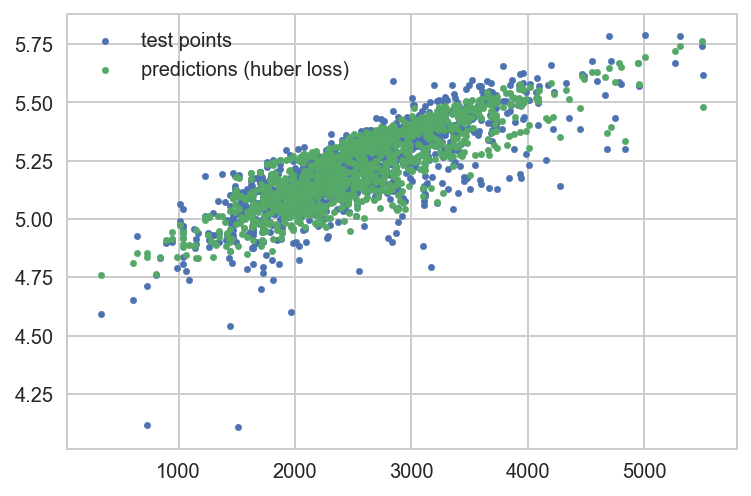

In [18]:
# Plot models
sale_price = X_te[:, 0] 
plt.scatter(sale_price, y_te, s=10, label='test points')
plt.scatter(sale_price, y_pred_hl, s=10, label='predictions (huber loss)')
plt.legend()
plt.show()

### Understanding the error metric

FRED:
You can get the MAE scores in dollars by raising your predictions to power 10: MAE(10**y_te, 10**y_pred) where y_te and y_pred are in "log10-dollars". In this project, the MAE metric is very important to get a more intuitive score to report - an MAE of 50,000 means that your predictions are on average 50 thousand dollars away from the observed price. Thanks for asking.

In [ ]:
# Final comparison
mae_values = [mae_baseline, mae_lr, mae_lr2, mae_wdnwd]
titles = ['median', 'lr', 'lr new features', 'two models']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()